## ATTENTION: code in this notebook might be outdated. It was used for training all models with squeezenet which are highlighted in final report.

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=aa10d4b32b4bd0eb3d96e5ae22afcb8bc17fad2f5820e69070dd76d11ead8558
  Stored in directory: /root/.cache/pip/wheels/f5/ce/f7/7039d7b57e1a27fc2f6bb2b2abed1be362eefece03caf2fb9a
Successfully built colormath


In [ ]:
pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
pip install clean-fid

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from torchvision.models import squeezenet1_1,SqueezeNet1_1_Weights
from torchvision.models.squeezenet import Fire
from torch import nn, optim
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage import io,color
from google.colab import files,drive
import pandas as pd
import shutil
import os
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import time
import cv2
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from cleanfid import fid
from torch.optim import Adam # forgot

cuda


# Dataloader

In [ ]:
class PairedNumpyDataset(Dataset):
    def __init__(self, gt_paths,img_format="jpg"):
        self.gt_paths = gt_paths  # List of ground truth .npy file paths
        self.img_format = img_format

    def __getitem__(self, index):
        # Load ground truth image from .npy file
        if self.img_format == "npy":
            gt_img = np.load(self.gt_paths[index])  # Shape: (N, M, 3)
            gt_img = np.transpose(gt_img, (2, 0, 1))  # Convert to (3, N, M)
            gt_img = torch.from_numpy(gt_img).float()
        else:
            gt_img = io.imread(self.gt_paths[index])
            gt_img = color.rgb2lab(gt_img)
            gt_img = norm_lab_img(gt_img)
            gt_img = np.transpose(gt_img, (2, 0, 1))
            gt_img = torch.from_numpy(gt_img).float()


        L = gt_img[0].unsqueeze(0)
        ab = gt_img[1:]

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.gt_paths)

def files_names_list(N,start_index,gt_path,prefix="lab",suffix=".npy"):
    gt_name_list = []
    for i in range(start_index,start_index+N):
        im_num = i+1
        gt_name_list.append(gt_path+"/"+prefix+str(im_num)+suffix)

    return gt_name_list

# Models

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, net_D=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        if net_D is None:
            self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        else:
            self.net_D = net_D.to(self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## Unet


In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 6):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

## Discriminator

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)]

        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]

        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## ResNet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

## Squeezenet


In [ ]:
def build_squeeze_unet(n_input=1, n_output=2, size=256,sa=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model = squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)


    if n_input != 3:
        original_first_layer = model.features[0]
        model.features[0] = nn.Conv2d(
            n_input,
            original_first_layer.out_channels,
            kernel_size=original_first_layer.kernel_size,
            stride=original_first_layer.stride,
            padding=original_first_layer.padding
        )


        if n_input == 1:
            with torch.no_grad():
                model.features[0].weight.data = original_first_layer.weight.data.mean(dim=1, keepdim=True)
                model.features[0].bias.data = original_first_layer.bias.data


    encoder = model.features


    net_G = DynamicUnet(
        encoder,
        n_output,
        (size, size),
        blur=True,
        self_attention=sa,
        y_range=None
    ).to(device)

    return net_G

small_Gnet = build_squeeze_unet(n_input=1, n_output=2, size=128)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 58.0MB/s]


# Utility

## Training

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def torch_to_numpy(img_tensor):
    """
    Converts a PyTorch image tensor (C, H, W) to a NumPy array (H, W, C).

    Args:
        img_tensor (torch.Tensor): Input tensor with shape (C, H, W).

    Returns:
        np.ndarray: Converted NumPy array with shape (H, W, C).
    """
    if not isinstance(img_tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor")

    if img_tensor.ndim != 3:
        raise ValueError("Expected a 3D tensor (C, H, W), but got shape {}".format(img_tensor.shape))

    img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) -> (H, W, C)
    return img_numpy


def lab_to_rgb(L, ab):
    # Takes a batch of images

    L = (L + 1.) * 50.
    ab = ab * 110.

    if np.any(L.cpu().numpy() < 0) or np.any(L.cpu().numpy() > 100):
      print(f"Invalid L range [0-100]. Detected range: {L.min():.2f}-{L.max():.2f}")

    # For ab channels (should be -128 to 127)
    ab_min = ab.cpu().numpy().min()
    ab_max = ab.cpu().numpy().max()
    if ab_min < -128 or ab_max > 127:
      print(f"Invalid ab range [-128-127]. Detected range: {ab_min:.2f}-{ab_max:.2f}")

    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = color.lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def visualize(model, data, save=True,benchmark_colorization = True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")

        histogram_error = color_histogram_similarity(real_imgs[i],fake_imgs[i])
        histogram_error = np.round(histogram_error,2)

        psnr_error = calculate_psnr(real_imgs[i],fake_imgs[i])
        psnr_error = np.round(psnr_error,2)

         # Add text under the undermost picture (real colorized image)
        ax.text(0.5, -0.15, f"hist: {histogram_error} \n psnr: {psnr_error}", transform=ax.transAxes,
                fontsize=12, ha='center', va='center')
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")


def calculate_scores(model, data,model_name=None):
    model.net_G.eval()
    psnr_list = []
    hist_list = []

    with torch.no_grad():
        # Process all batches in the DataLoader
        for b,batch in enumerate(data):
            # Load and process batch
            model.setup_input(batch)
            model.forward()

            # Get outputs and convert to numpy
            fake_color = model.fake_color.detach()
            real_color = model.ab
            L = model.L

            # Convert LAB to RGB images
            fake_imgs = lab_to_rgb(L, fake_color)
            real_imgs = lab_to_rgb(L, real_color)

            if model_name is not None:
                os.makedirs(f"/content/drive/MyDrive/fake_img_facerec/fake_images_{model_name}",exist_ok= True)
                batch_size = batch["L"].shape[0]
                # save the genrated images for later benchmarking
                for i in range(fake_imgs.shape[0]):
                    img = fake_imgs[i]
                    img = img.astype('uint8')
                    Image.fromarray(img).save(f'/content/drive/MyDrive/fake_img_facerec/fake_images_{model_name}/{b*batch_size + i}.png')



            # Calculate metrics for each image in batch
            batch_size = real_imgs.shape[0]
            for i in range(batch_size):
                # Histogram similarity
                hist_error = color_histogram_similarity(real_imgs[i], fake_imgs[i])
                hist_list.append(round(hist_error, 2))

                # PSNR calculation
                psnr_error = calculate_psnr(real_imgs[i], fake_imgs[i])
                psnr_list.append(round(psnr_error, 2))

    # Calculate statistics
    psnr_mean = np.mean(psnr_list)
    psnr_var = np.var(psnr_list)
    hist_mean = np.mean(hist_list)
    hist_var = np.var(hist_list)

    return [psnr_list, psnr_mean, psnr_var], [hist_list, hist_mean, hist_var]

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


def norm_lab_img(lab_img):
    """Convert LAB image to normalized range [-1,1]."""
    lab_img[:, :, 0] = (lab_img[:, :, 0] - 0) / (100 - 0) * 2 - 1  # Scale L from [0,100] → [-1,1]
    lab_img[:, :, 1] = (lab_img[:, :, 1] + 128) / (127 + 128) * 2 - 1  # Scale a from [-128,127] → [-1,1]
    lab_img[:, :, 2] = (lab_img[:, :, 2] + 128) / (127 + 128) * 2 - 1  # Scale b from [-128,127] → [-1,1]

    return lab_img

def unnorm_lab_img(normalized_lab_img):
    """Convert LAB image from [-1,1] range back to original LAB range."""
    normalized_lab_img[:, :, 0] = ((normalized_lab_img[:, :, 0] + 1) / 2) * 100  # Convert L from [-1,1] → [0,100]
    normalized_lab_img[:, :, 1] = ((normalized_lab_img[:, :, 1] + 1) / 2) * (127 + 128) - 128  # Convert a from [-1,1] → [-128,127]
    normalized_lab_img[:, :, 2] = ((normalized_lab_img[:, :, 2] + 1) / 2) * (127 + 128) - 128  # Convert b from [-1,1] → [-128,127]

    return normalized_lab_img

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')


def save_metrics(epoch_loss_list, psnr_list, hist_list, filename="metrics.csv"):
    """
    Saves the given lists into a CSV file using pandas.

    Args:
        epoch_loss_list (list): List of epoch losses.
        psnr_list (list): List of PSNR values.
        hist_list (list): List of histogram values.
        filename (str): Name of the output CSV file.
    """

    # Create a DataFrame
    df = pd.DataFrame({
        'Epoch Loss': epoch_loss_list,
        'PSNR': psnr_list,
        'Histogram': hist_list
    })

    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")


In [ ]:
def train_model(model, train_dl, epochs,val_dl,vis_data,display_every=1,timestamp_save=None,drive_path=None,model_name=None):
    val_data = val_dl
    psnr_list, hist_list = [],[]
    epoch_loss_list, epoch_loss_list_val = [],[]
    for e in range(epochs):
        model.train()
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
        i += 1
        epoch_loss_list.append(loss_meter_dict['loss_G_GAN'].avg)

        psnr, hist = calculate_scores(model, val_data)
        psnr_list.append(psnr[1])
        hist_list.append(hist[1])

        model.eval()  # Set model to evaluation mode
        val_loss_meter = create_loss_meters()

        with torch.no_grad():
          for data in val_data:

              model.setup_input(data)
              model.forward()  # Forward pass only
              update_losses(model, val_loss_meter, count=data['L'].size(0))  # Log validation loss

          epoch_loss_list_val.append(val_loss_meter['loss_G_GAN'].avg)


        if i % display_every == 0:
            print(f"\nEpoch {e+1}/{epochs}")
            print(f"Iteration {i}/{len(train_dl)}")
            log_results(loss_meter_dict) # function to print out the losses
            visualize(model, vis_data, save=False) # function displaying the model's outputs
            print(f"psnr mean: {psnr[1]}, var: {psnr[2]}")
            print(f"hist mean: {hist[1]}, var: {hist[2]}")

        if timestamp_save is not None and e % 5 == 0:
            save_full_model(model, drive_path,model_name=model_name,timestamp=timestamp_save)
            save_metrics(epoch_loss_list, psnr_list, hist_list, filename=f"{drive_path}/metrics_{model_name}_{timestamp_save}.csv")

    save_metrics(epoch_loss_list, psnr_list, hist_list, filename=f"{drive_path}/metrics_{model_name}_{timestamp_save}.csv")

    plt.plot(psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('PSNR vs Epoch')
    plt.show()

    plt.plot(hist_list)
    plt.xlabel('Epoch')
    plt.ylabel('Color Histogram Similarity')
    plt.title('Color Histogram Similarity vs Epoch')
    plt.show()

    plt.plot(epoch_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show()

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [ ]:
def pretrain_discriminator(dataloader, net_G, gentype,num_epochs=4):
    # Hyperparameters
    input_channels = 3  # L + ab channels concatenated
    num_filters = 64
    n_down = 3
    lr = 2e-4

    # Initialize components
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    D = PatchDiscriminator(input_c=input_channels, num_filters=num_filters, n_down=n_down).to(device)
    optimizer_D = Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.BCEWithLogitsLoss()  # Proper loss for raw logits

    # Dataloader (example with CIFAR-10)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Training loop
    for epoch in range(num_epochs):
        for i, data in tqdm(enumerate(dataloader)):
            # Get batch of real images
            L, ab = data['L'].to(device), data['ab'].to(device)
            real_images = torch.cat([L, ab], dim=1) #real_images[0].to(device)  # CIFAR10 returns (img, label)
            batch_size = real_images.size(0)

            # Generate fake images (simulated with noise)
            # Replace with generator output in real use cases
            fake_ab = net_G(L) #torch.randn_like(real_images).to(device)

            fake_images = torch.cat([L, fake_ab], dim=1)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Real images forward pass
            real_outputs = D(real_images)
            real_labels = torch.ones_like(real_outputs)  # Auto-shaped labels

            # Fake images forward pass
            fake_outputs = D(fake_images.detach())  # Detach to prevent generator training
            fake_labels = torch.zeros_like(fake_outputs)

            # Calculate losses
            loss_real = criterion(real_outputs, real_labels)
            loss_fake = criterion(fake_outputs, fake_labels)
            loss_D = (loss_real + loss_fake) / 2

            # Backpropagation
            loss_D.backward()
            optimizer_D.step()

            # Logging
            if i % 2 == 0:
                current_batch = real_images.shape[2]  # Get image size
                Acc1 = torch.sigmoid(real_outputs).mean().item()
                Acc2 = torch.sigmoid(fake_outputs).mean().item()
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(dataloader)}] "
                      f"Loss D: {loss_D.item():.4f} "
                      f"Real Acc: {Acc1:.2f} "
                      f"Fake Acc: {1- Acc2:.2f}")
                if Acc1 > 0.7 and ((1 - Acc2)>0.7):
                  break


    print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
              f"Loss D: {loss_D.item():.4f} "
              f"Real Acc: {torch.sigmoid(real_outputs).mean().item():.2f} "
              f"Fake Acc: {1 - torch.sigmoid(fake_outputs).mean().item():.2f}")

    # Save final model
    #time_stamp = time.strftime("%Y%m%d-%H%M%S")
    #torch.save(D.state_dict(), f"/content/drive/MyDrive/ColorationModelsFaces/patch_discriminator_{gentype}_ne{num_epochs}_{time_stamp}.pth")
    return D

In [ ]:
def save_full_model(model, save_path,model_name,timestamp, drive_mount=True):
    """Save complete model state to disk"""
    if drive_mount:
        drive.mount('/content/drive', force_remount=True)

    # Save checkpoints with timestamps

    full_save_path = f"{save_path}/{model_name}_{timestamp}.pt"

    torch.save({
        'generator_state': model.net_G.state_dict(),
        'discriminator_state': model.net_D.state_dict(),
        'optimizerG_state': model.opt_G.state_dict(),
        'optimizerD_state': model.opt_D.state_dict(),
        'model_params': {
            'lambda_L1': model.lambda_L1,
            'device': model.device
        }
    }, full_save_path)

    print(f"Model saved to {full_save_path}")
    return full_save_path

In [ ]:
def load_full_model(save_path, map_location=None,resnet=False,squeezenet=False,squeezenet_sa=False,Unet=False):
    """Load complete model state from disk"""
    if map_location is None:
        map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint = torch.load(save_path, map_location=map_location)

    if resnet:
      # Rebuild model architecture
      net_G = build_res_unet(n_input=1, n_output=2, size=128)
      model = MainModel(net_G=net_G)
    if squeezenet:
      net_G = build_squeeze_unet(n_input=1, n_output=2, size=128)
      model = MainModel(net_G=net_G)
    if Unet:
      model = MainModel()

    if resnet or squeezenet or squeezenet_sa:
      # Load states
      model.net_G.load_state_dict(checkpoint['generator_state'])
      model.net_D.load_state_dict(checkpoint['discriminator_state'])
      model.opt_G.load_state_dict(checkpoint['optimizerG_state'])
      model.opt_D.load_state_dict(checkpoint['optimizerD_state'])
    else:
      model.load_state_dict(checkpoint['model_state_dict'])
      model.opt_G.load_state_dict(checkpoint['optimizerG_state_dict'])

    if resnet or squeezenet or squeezenet_sa:
      # Load parameters
      model.lambda_L1 = checkpoint['model_params']['lambda_L1']
      model.device = checkpoint['model_params']['device']
      #model.to(model.device)
    else:
      pass


    return model

## Scoring

In [ ]:
def calculate_psnr(image1, image2):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        image1 (numpy.ndarray): First image (ground truth).
        image2 (numpy.ndarray): Second image (predicted/reconstructed).

    Returns:
        float: PSNR score (higher values indicate better quality).
    """
    # Ensure the images are in the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")

    # Calculate MSE (Mean Squared Error)
    mse = np.mean((image1 - image2) ** 2)

    # Handle the case where MSE is zero (identical images)
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    max_pixel = 255.0 if image1.dtype == np.uint8 else 1.0
    psnr_score = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr_score

def calculate_color_histogram(image, bins=8):
    """
    Calculate the color histogram of an image.

    Args:
        image (numpy.ndarray): Input image in BGR format.
        bins (int): Number of bins for each channel.

    Returns:
        numpy.ndarray: Flattened color histogram.
    """
    # Convert the image to HSV color space (optional, can use RGB as well)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the histogram for each channel
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins], [0, 180])  # Hue
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])  # Saturation
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])  # Value

    # Normalize the histograms
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    # Concatenate the histograms into a single feature vector
    hist = np.hstack([hist_h, hist_s, hist_v])
    return hist


def color_histogram_similarity(image1, image2, bins=8):
    """
    Calculate the color histogram similarity between two images.

    Args:
        image1 (numpy.ndarray): First image in BGR format.
        image2 (numpy.ndarray): Second image in BGR format.
        bins (int): Number of bins for each channel.

    Returns:
        float: Similarity score (higher values indicate greater similarity).
    """
    # Calculate histograms for both images
    hist1 = calculate_color_histogram(image1, bins)
    hist2 = calculate_color_histogram(image2, bins)

    # Compute cosine similarity between the histograms
    similarity = cosine_similarity(hist1.reshape(1, -1), hist2.reshape(1, -1))
    return similarity[0][0]



# Run


In [ ]:
# Run params

time_stamp = "0304-1730"
drive_path = "/content/drive/MyDrive/ColorationModels_final128"
os.makedirs(drive_path,exist_ok=True)

drive_data_dir = "/content/drive/MyDrive/mixed128"

drive_path_val = "/content/drive/MyDrive/val_faces128"
drive_data_dir_val = drive_path_val

drive_path_fake = "/content/drive/MyDrive/fake_img_facerec/fake_img"


In [ ]:
n_files_train = 4000
n_files_val = 100
image_size = 128

## Define Dataloader

In [ ]:
# Load files from Google Drive (no re-upload needed
file_list_train = [] #[os.path.join(drive_data_dir, f) for f in os.listdir(drive_data_dir)]
all_files_in_folder = os.listdir(drive_data_dir)


for i in range(n_files_train):
  file_list_train.append(os.path.join(drive_data_dir, all_files_in_folder[i]))


file_list_val =  [] #[os.path.join(drive_data_dir_val, f) for f in os.listdir(drive_data_dir_val)]
all_files_in_folder = os.listdir(drive_data_dir_val)

for i in range(n_files_val):
  file_list_val.append(os.path.join(drive_data_dir_val, all_files_in_folder[i]))


print("Files loaded from Google Drive:", file_list_train)


train = PairedNumpyDataset(file_list_train)
val = PairedNumpyDataset(file_list_val)
print(len(train),len(val))

t_dataloader = DataLoader(train, batch_size=16, num_workers=4, pin_memory=True, shuffle=True)
v_dataloader = DataLoader(val, batch_size=20, num_workers=4, pin_memory=True, shuffle=True) # so we can see the same images
vis_dataloader = DataLoader(val, batch_size=5, num_workers=4, pin_memory=True, shuffle=False) # so we can see the same images

test_data = next(iter(vis_dataloader)) # defined without shuffle above for easy compare


Files loaded from Google Drive: ['/content/drive/MyDrive/mixed128/503c.jpg', '/content/drive/MyDrive/mixed128/501c.jpg', '/content/drive/MyDrive/mixed128/500c.jpg', '/content/drive/MyDrive/mixed128/507c.jpg', '/content/drive/MyDrive/mixed128/504c.jpg', '/content/drive/MyDrive/mixed128/506c.jpg', '/content/drive/MyDrive/mixed128/505c.jpg', '/content/drive/MyDrive/mixed128/508c.jpg', '/content/drive/MyDrive/mixed128/509c.jpg', '/content/drive/MyDrive/mixed128/510c.jpg', '/content/drive/MyDrive/mixed128/511c.jpg', '/content/drive/MyDrive/mixed128/515c.jpg', '/content/drive/MyDrive/mixed128/512c.jpg', '/content/drive/MyDrive/mixed128/514c.jpg', '/content/drive/MyDrive/mixed128/513c.jpg', '/content/drive/MyDrive/mixed128/517c.jpg', '/content/drive/MyDrive/mixed128/518c.jpg', '/content/drive/MyDrive/mixed128/516c.jpg', '/content/drive/MyDrive/mixed128/519c.jpg', '/content/drive/MyDrive/mixed128/521c.jpg', '/content/drive/MyDrive/mixed128/520c.jpg', '/content/drive/MyDrive/mixed128/523c.jpg',

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## PUG

In [ ]:
model_name = "PUG"

Unet_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), device)

opt = optim.Adam(Unet_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(Unet_G, t_dataloader, opt, criterion, 20)

 # Save to Drive
torch.save(Unet_G.state_dict(), f"{drive_path}/{model_name}_{time_stamp}.pt")

model initialized with norm initialization


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.17368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.15454


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# model is saved so we can figure out error
only_Unet_G_model = MainModel(net_G=Unet_G)
visualize(only_Unet_G_model,data=test_data,save=True)
psnr_list, hist_list = calculate_scores(only_Unet_G_model,v_dataloader)


## GU

In [ ]:
model_name = "GU"
model = MainModel()
train_model(model, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # ca 30 min with T4
save_full_model(model, drive_path,model_name=model_name,timestamp=time_stamp)

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load(f'{drive_path}/{model_name}_{time_stamp}.pth')
loaded_model = MainModel()

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.opt_G.load_state_dict(checkpoint['optimizerG_state_dict'])
loaded_model.opt_D.load_state_dict(checkpoint['optimizerD_state_dict'])

loaded_model.eval()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColorationModelsFaceRec256/GU_0104-2130.pth'

In [ ]:
visualize(loaded_model, test_data, save=True) # not the same image processing as the model was trained on
psnr_list, hist_list = calculate_scores(loaded_model, v_dataloader)

## ResNet


In [ ]:
model_name = "PRG"
net_G = build_res_unet(n_input=1, n_output=2, size=image_size)

opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, t_dataloader, opt, criterion, 20) # ca 30 min

 # Save to Drive
torch.save(net_G.state_dict(), f"{drive_path}/{model_name}_{time_stamp}.pt")

In [ ]:
#put together with discriminator
net_G_load = build_res_unet(n_input=1, n_output=2, size=256)

net_G_load.load_state_dict(torch.load(f"{drive_path}/{model_name}_{time_stamp}.pt", map_location=device))
only_net_G_model = MainModel(net_G=net_G_load)
visualize(only_net_G_model,data=test_data,save=True)
psnr_list, hist_list = calculate_scores(only_net_G_model, v_dataloader)

In [ ]:
# GAN training
model_name = "GPRG"
full_model = MainModel(net_G=net_G_load) # net_G
train_model(full_model, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # 40 min
model_save_path =  save_full_model(full_model, drive_path,model_name=model_name,timestamp=time_stamp)

In [ ]:
# evaluation
model_save_path = f"{drive_path}/{model_name}_{time_stamp}.pt"
loaded_full_model = load_full_model(model_save_path,resnet=True)

visualize(loaded_full_model, test_data, save=True)
psnr_list, hist_list = calculate_scores(loaded_full_model, v_dataloader)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColorationModelsFaceRec256/GU_0104-2130.pt'

In [ ]:
# now try with pretrained Discriminator
model_name = "GPRGD"
D_res = pretrain_discriminator(t_dataloader, net_G, "resnet",num_epochs=1)

pretrain_small_D = MainModel(net_G=net_G, net_D=D_res)

train_model(pretrain_small_D, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # 20 min

## SqueezeNet

In [ ]:
# Pretrain
model_name = "PSG"
small_Gnet = build_squeeze_unet(n_input=1, n_output=2, size=image_size)
opt = optim.Adam(small_Gnet.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(small_Gnet, t_dataloader, opt, criterion, 20) # 10 min

torch.save(small_Gnet.state_dict(), f"{drive_path}/{model_name}_{time_stamp}.pt")

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.11466


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.06240


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.06011


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.05888


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.05808


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.05785


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.05719


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.05663


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.05585


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.05581


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.05514


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.05444


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.05347


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.05261


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.05155


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.05011


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.04918


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.04839


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.04663


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.04537


model initialized with norm initialization


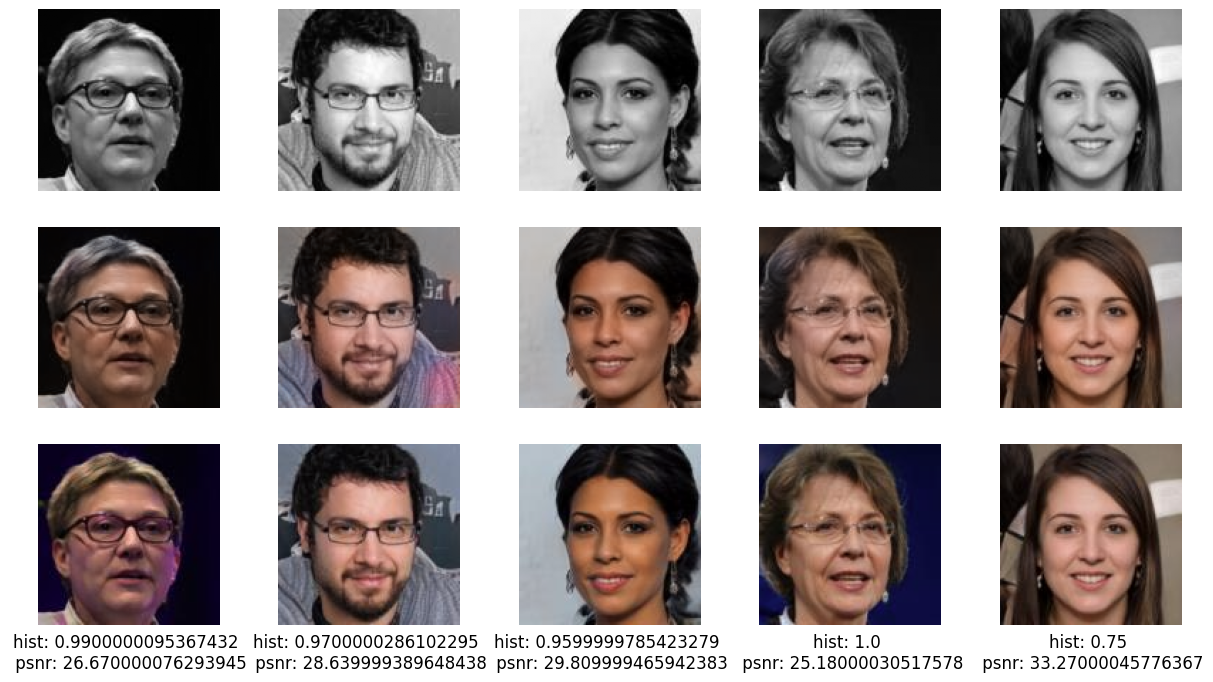

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# eval
model_name = "PSG"
small_net_G_load = build_squeeze_unet(n_input=1, n_output=2, size=image_size)
small_net_G_load.load_state_dict(torch.load(f"{drive_path}/{model_name}_{time_stamp}.pt", map_location=device))
only_smallnet_G_model = MainModel(net_G=small_net_G_load)

visualize(only_smallnet_G_model,data=test_data,save=True)
psnr_list, hist_list = calculate_scores(only_smallnet_G_model, v_dataloader)

In [ ]:
# GAN train
model_name = "GPSG"
full_model_small = MainModel(net_G=small_net_G_load)
train_model(full_model_small, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # 20 min
model_save_path = save_full_model(full_model_small, drive_path,model_name=model_name,timestamp=time_stamp)

Output hidden; open in https://colab.research.google.com to view.

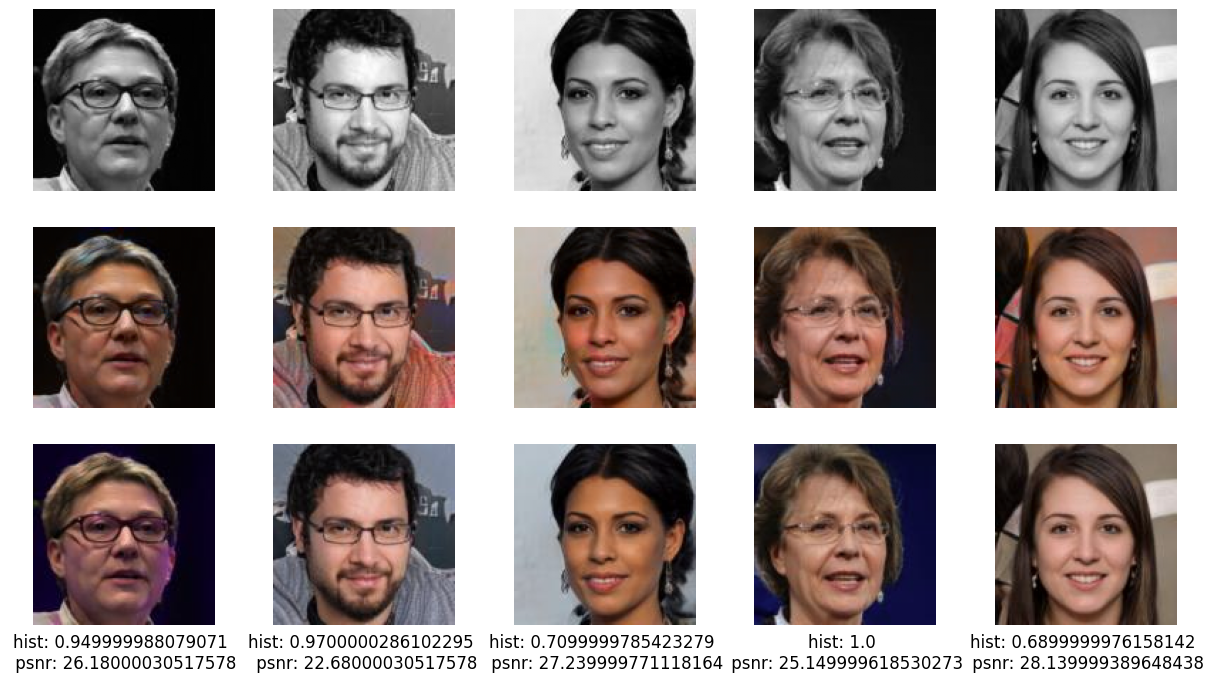

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# eval GAN
visualize(full_model_small, test_data, save=True)
psnr_list, hist_list = calculate_scores(full_model_small, v_dataloader)

In [ ]:
# now try with pretrained Discriminator
model_name = "GPSGD"
D_squeeze = pretrain_discriminator(t_dataloader, small_net_G_load, "squeezenet",num_epochs=1)

pretrain_small_D = MainModel(net_G=small_net_G_load,net_D=D_squeeze)

train_model(pretrain_small_D, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # 20 min

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-44-406f45211154>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img)
<ipython-input-44-406f45211154>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img)


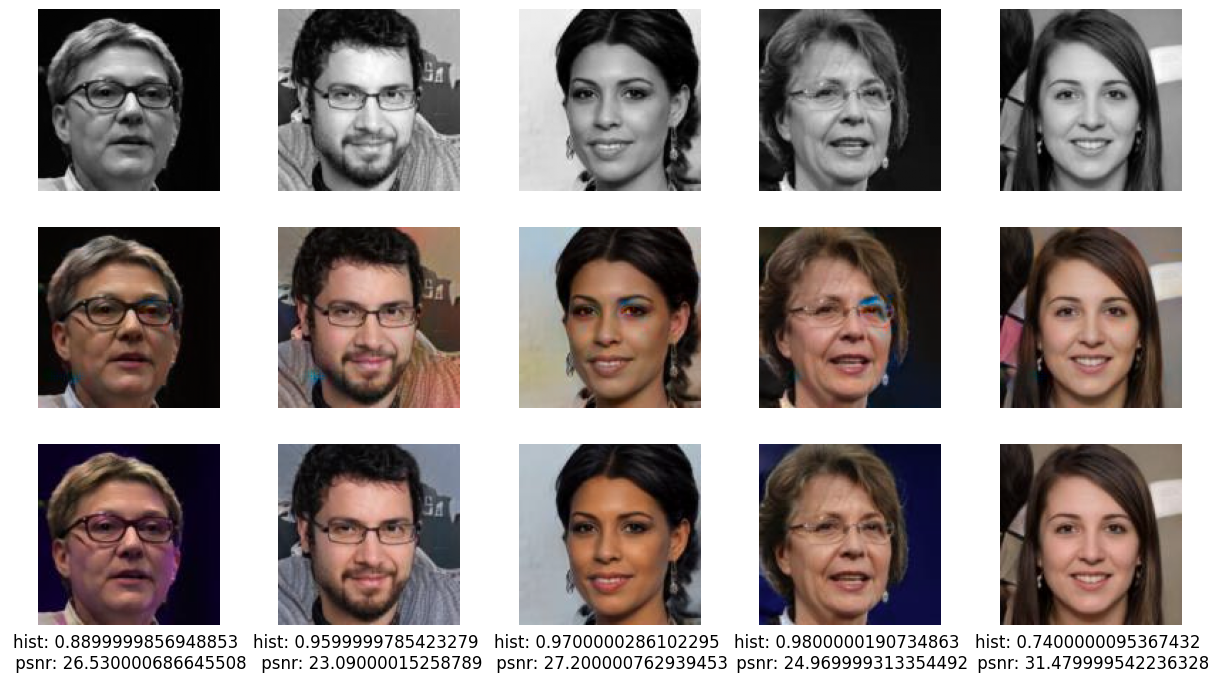

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-44-406f45211154>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 19 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img)
<ipython-input-44-406f45211154>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img)
<ipython-input-44-406f45211154>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been cli

In [ ]:
visualize(pretrain_small_D,data=test_data,save=True)
psnr_list, hist_list = calculate_scores(only_smallnet_G_model, v_dataloader)

## SqueezeNet sa

In [ ]:
# Pretrain
model_name = "PSAG"
small_Gnet = build_squeeze_unet(n_input=1, n_output=2, size=image_size,sa=True)
opt = optim.Adam(small_Gnet.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(small_Gnet, t_dataloader, opt, criterion, 20) # 10 min

torch.save(small_Gnet.state_dict(), f"{drive_path}/{model_name}_{time_stamp}.pt")

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20
L1 Loss: 0.10233


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.06164


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.05962


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.05837


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.05715


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.05682


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.05579


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.05494


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.05376


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.05285


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.05149


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.04992


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.04914


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.04737


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.04528


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.04364


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.04229


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.04084


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.03904


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.03766


model initialized with norm initialization


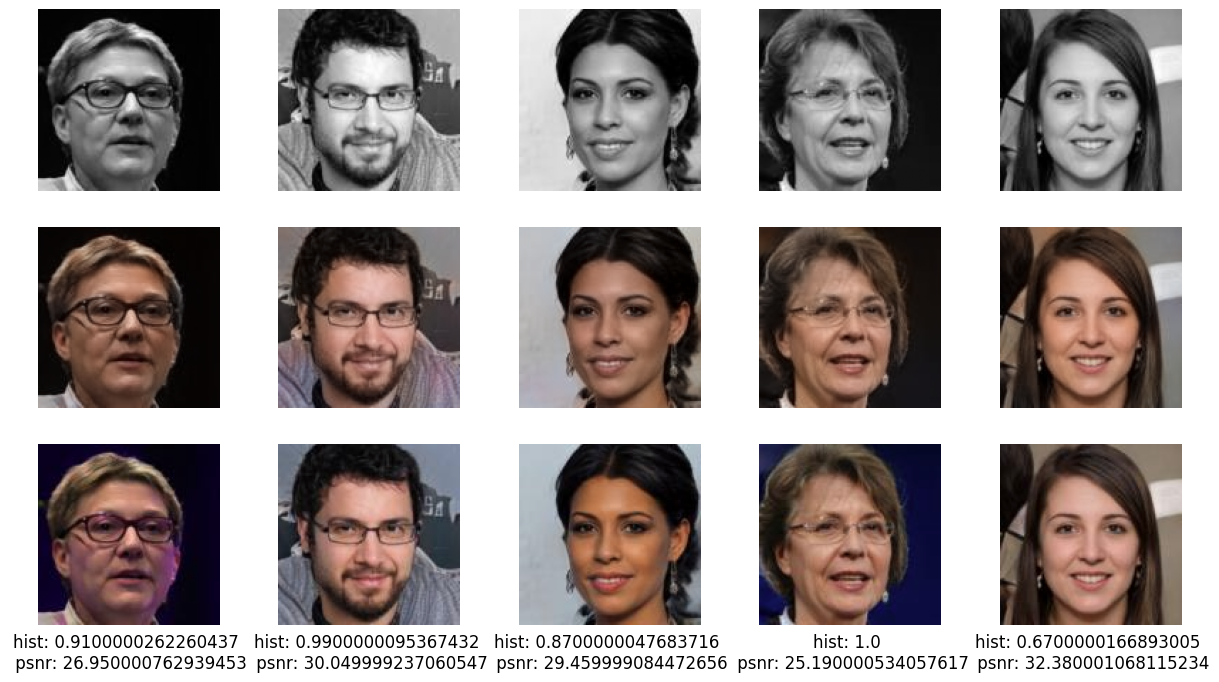

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# eval
small_net_G_load = build_squeeze_unet(n_input=1, n_output=2, size=image_size,sa=True)
small_net_G_load.load_state_dict(torch.load(f"{drive_path}/{model_name}_{time_stamp}.pt", map_location=device))
only_smallnet_G_model = MainModel(net_G=small_net_G_load)

visualize(only_smallnet_G_model,data=test_data,save=True)
psnr_list, hist_list = calculate_scores(only_smallnet_G_model, v_dataloader)

In [ ]:
# GAN train
model_name = "GPSAG"
full_model_small = MainModel(net_G=small_net_G_load)
train_model(full_model_small, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # 20 min
model_save_path = save_full_model(full_model_small, drive_path,model_name=model_name,timestamp=time_stamp)

Output hidden; open in https://colab.research.google.com to view.

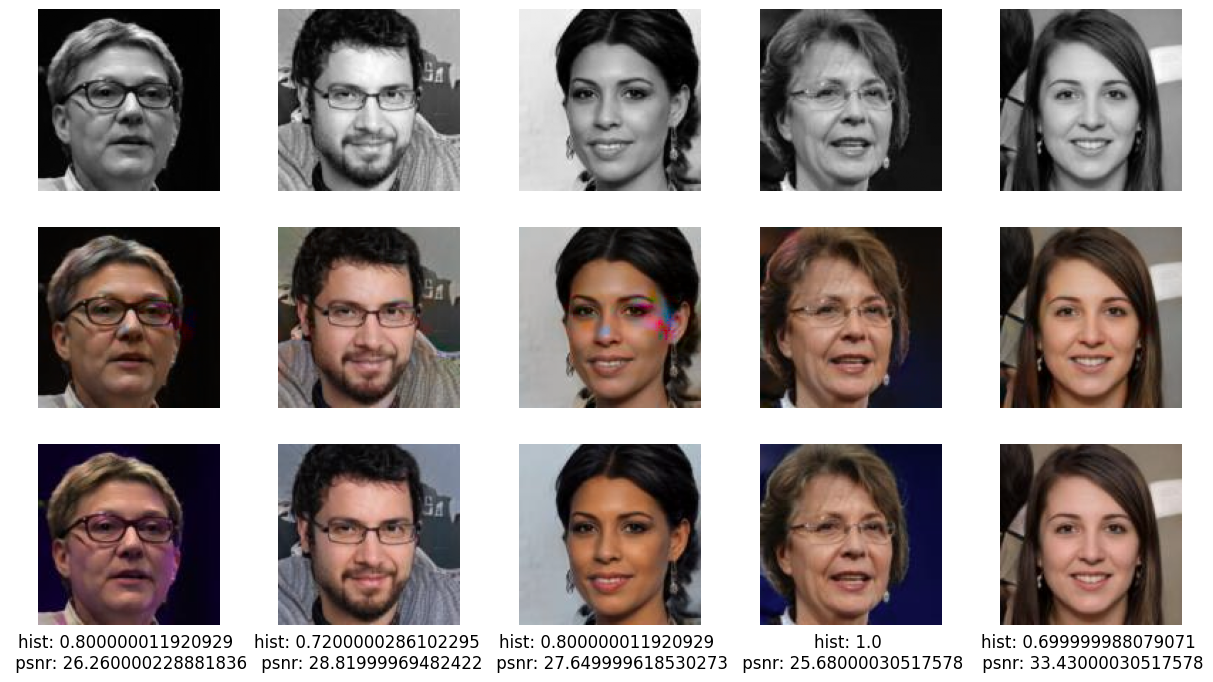

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-14-406f45211154>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img)


In [ ]:
# eval GAN
visualize(full_model_small, test_data, save=True)
psnr_list, hist_list = calculate_scores(full_model_small, v_dataloader)

In [ ]:
# now try with pretrained Discriminator
model_name = "GPSAGD"
D_squeeze = pretrain_discriminator(t_dataloader, small_Gnet, "squeezenet",num_epochs=1)

pretrain_small_D = MainModel(net_G=small_net_G_load,net_D=D_squeeze)

train_model(pretrain_small_D, t_dataloader, 20,val_dl=v_dataloader,vis_data=test_data,drive_path=drive_path,model_name=model_name,timestamp_save=time_stamp) # 20 min

Output hidden; open in https://colab.research.google.com to view.

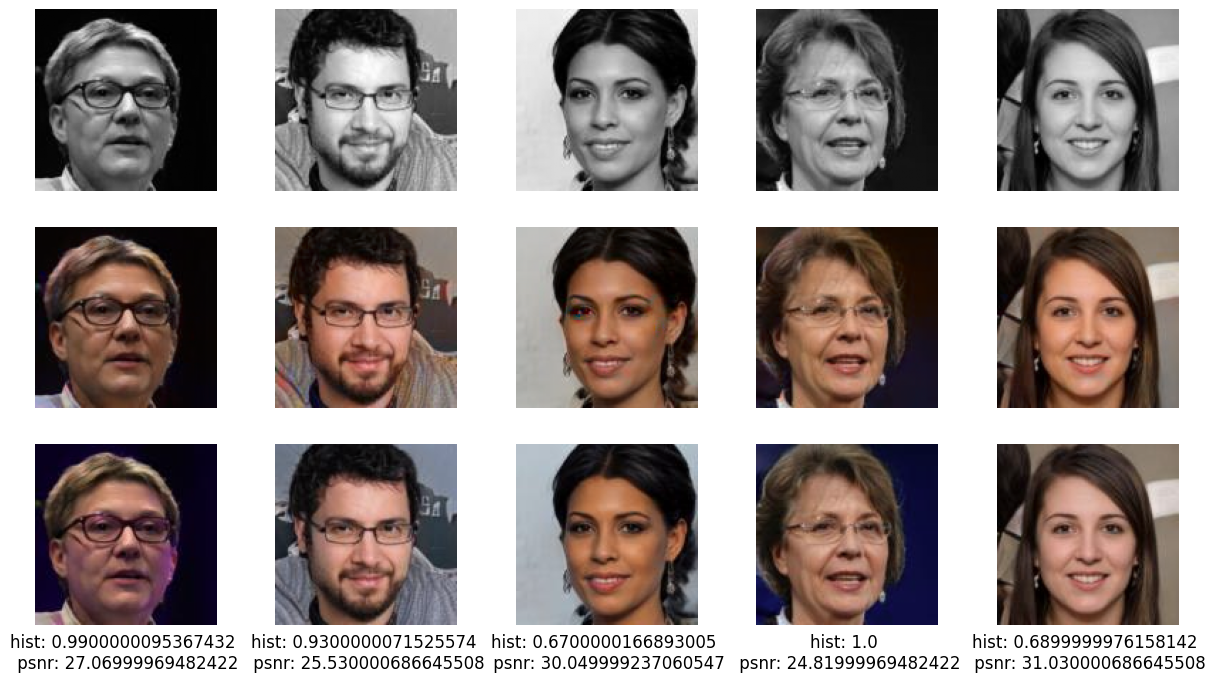

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
visualize(pretrain_small_D,data=test_data,save=True)
psnr_list, hist_list = calculate_scores(pretrain_small_D, v_dataloader)